In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
n = 80
data = pd.DataFrame({
    "temperature_C": np.random.normal(loc=24, scale=3.0, size=n).clip(16, 34).round(1),
    "humidity_pct": np.random.normal(loc=50, scale=10.0, size=n).clip(25, 80).round(1),
    "noise_db": np.random.normal(loc=48, scale=12.0, size=n).clip(25, 85).round(1)
})

def trap_mf(x, a, b, c, d):
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    left = (x >= a) & (x < b)
    y[left] = (x[left] - a) / (b - a + 1e-9)
    plateau = (x >= b) & (x <= c)
    y[plateau] = 1.0
    right = (x > c) & (x <= d)
    y[right] = (d - x[right]) / (d - c + 1e-9)
    return y

def tri_mf(x, a, b, c):
    return trap_mf(x, a, b, b, c)


In [3]:
# Membership untuk suhu, kelembapan, dan kebisingan
data['temp_cold_deg'] = trap_mf(data['temperature_C'], 16,16,18,21)
data['temp_comfy_deg'] = tri_mf(data['temperature_C'],20,24,26)
data['temp_hot_deg']   = trap_mf(data['temperature_C'],25,28,34,34)

data['hum_dry_deg']   = trap_mf(data['humidity_pct'],25,25,35,45)
data['hum_comfy_deg'] = tri_mf(data['humidity_pct'],40,50,60)
data['hum_humid_deg'] = trap_mf(data['humidity_pct'],55,65,80,80)

data['noise_quiet_deg'] = trap_mf(data['noise_db'],25,25,30,45)
data['noise_mod_deg']   = tri_mf(data['noise_db'],40,50,60)
data['noise_loud_deg']  = trap_mf(data['noise_db'],55,70,85,85)


In [4]:
temp_comfy = data['temp_comfy_deg']
hum_comfy  = data['hum_comfy_deg']
noise_quiet = data['noise_quiet_deg']

r1 = np.minimum(np.minimum(temp_comfy, hum_comfy), noise_quiet)
r2 = np.maximum.reduce([
    data['temp_cold_deg'], data['temp_hot_deg'],
    data['hum_humid_deg'], data['hum_dry_deg'], data['noise_loud_deg']
])
r3 = np.clip(1 - np.maximum(r1, r2), 0, 1)

data['rule_Comfortable_deg'] = r1
data['rule_Uncomfortable_deg'] = r2
data['rule_Slightly_deg'] = r3

output_centers = {"Uncomfortable": 20, "Slightly": 50, "Comfortable": 80}
num = (data['rule_Comfortable_deg'] * output_centers['Comfortable'] +
       data['rule_Slightly_deg'] * output_centers['Slightly'] +
       data['rule_Uncomfortable_deg'] * output_centers['Uncomfortable'])
den = (data['rule_Comfortable_deg'] + data['rule_Slightly_deg'] + data['rule_Uncomfortable_deg']) + 1e-9
data['comfort_score'] = (num / den).round(2)


In [5]:
def comfort_category(score):
    if score >= 70:
        return "Comfortable"
    elif score >= 45:
        return "Slightly_Comfy"
    else:
        return "Uncomfortable"

data['comfort_category'] = data['comfort_score'].apply(comfort_category)
data['needs_action'] = data['comfort_score'] < 50

# Tampilkan sebagian data
data.head(10)


,temperature_C,humidity_pct,noise_db,temp_cold_deg,temp_comfy_deg,temp_hot_deg,hum_dry_deg,hum_comfy_deg,hum_humid_deg,noise_quiet_deg,noise_mod_deg,noise_loud_deg,rule_Comfortable_deg,rule_Uncomfortable_deg,rule_Slightly_deg,comfort_score,comfort_category,needs_action
0,25.5,47.8,36.3,0.0,0.250,0.166667,0.00,0.78,0.00,0.580000,0.00,0.000000,0.25,0.166667,0.75,52.14,Slightly_Comfy,False
1,23.6,53.6,57.4,0.0,0.900,0.000000,0.00,0.64,0.00,0.000000,0.26,0.160000,0.00,0.160000,0.84,45.20,Slightly_Comfy,True
2,25.9,64.8,61.9,0.0,0.050,0.300000,0.00,0.00,0.98,0.000000,0.00,0.460000,0.00,0.980000,0.02,20.60,Uncomfortable,True
3,28.6,44.8,38.2,0.0,0.000,1.000000,0.02,0.48,0.00,0.453333,0.00,0.000000,0.00,1.000000,0.00,20.00,Uncomfortable,True
4,23.3,41.9,59.6,0.0,0.825,0.000000,0.31,0.19,0.00,0.000000,0.04,0.306667,0.00,0.310000,0.69,40.70,Uncomfortable,True
5,23.3,45.0,53.0,0.0,0.825,0.000000,0.00,0.50,0.00,0.000000,0.70,0.000000,0.00,0.000000,1.00,50.00,Slightly_Comfy,False
6,28.7,59.2,57.9,0.0,0.000,1.000000,0.00,0.08,0.42,0.000000,0.21,0.193333,0.00,1.000000,0.00,20.00,Uncomfortable,True
7,26.3,53.3,70.8,0.0,0.000,0.433333,0.00,0.67,0.00,0.000000,0.00,1.000000,0.00,1.000000,0.00,20.00,Uncomfortable,True
8,22.6,44.7,45.1,0.0,0.650,0.000000,0.03,0.47,0.00,0.000000,0.51,0.000000,0.00,0.030000,0.97,49.10,Slightly_Comfy,True
9,25.6,55.1,39.0,0.0,0.200,0.200000,0.00,0.49,0.01,0.400000,0.00,0.000000,0.20,0.200000,0.80,50.00,Slightly_Comfy,False


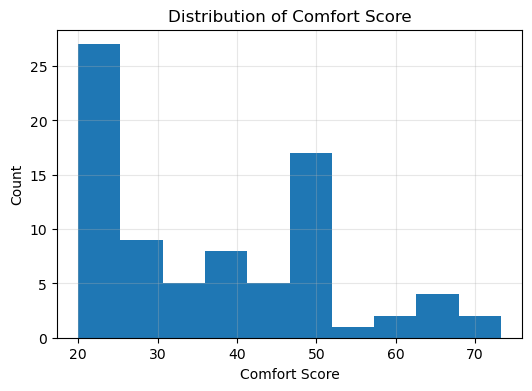

In [6]:
plt.figure(figsize=(6,4))
plt.hist(data['comfort_score'], bins=10)
plt.title("Distribution of Comfort Score")
plt.xlabel("Comfort Score")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()
